# Chapter 3 Part 1: the random sample
author: <span style="color:magenta">Poppy Riddle</span><br>
date: Mar 31, 2025

## Data collection
This notebook collects a random sample from Crossref. Inclusion criteria include:
- date range: 2020-2025
- doc_type:journal-article, proceedings-article, book-chapter
- filter: has-abstract=1
- sample: sample size is limited to 100 per call. Multiple calls will be used. 

Total records needed:
- journal articles = 9550 (95.5%),
- proceedings-article=150 (1.5%), 
- and book-chapter=290 (2.9%


<span style="color:magenta">## to do</span><br>
Pulling data from the XML API is a pain and is inconsistent particularly for abstract and license. 
- [x] Pull all data from REST API with full metadata (otherwise language is not part of select option)**COMPLETE**
    - [X] see crossref_api.py for REST api module


This makes getting the data for proceedings-article and book-chapter much easier and consistent. Otherwise, coding all the locations to get from the XML is too 
likely to have errors or false negatives. 

- [x] subset selection and collection
- [x] subset analysis


# Random selection

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import requests
import pickle
import json
from colorama import Fore,Back,Style
import time
import csv
from tqdm import tqdm
from crossref_api import Crossref_REST_API

# set display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column


In [39]:
# this cell gets the random DOIs for each doc_type

# doc_type is a dictionary that includes the type (key) to be inserted into the API_URL and the quantity (value) of times the API_URL needs to be called.
# *** see sample size below - each sample size is 100 (limit), so each number in the line below represents 100's
doc_type = {"journal-article":96, "proceedings-article":2, "book-chapter":3}

#API_URL = f"https://api.crossref.org/works?mailto=pnriddle@dal.ca&filter=from-pub-date:2020-01-01,has-abstract:1,type:{doc_type}&select=DOI&sample=10"

# URL and params - the requests library concats with &
# moved params to within the for loop
API_URL = "https://api.crossref.org/works?"

# dictionary of dataframes to store the results for each document type
dfs = {}

start = time.time()
# Send API calls for each document type and collect the results
for doc_type, num_samples in doc_type.items():
    params = {
    "mailto": "pnriddle@dal.ca",
    "filter": "from-pub-date:2020-01-01,has-abstract:1",
    "select": "DOI",
    "sample": 100}
    params["filter"] += f",type:{doc_type}"
    results = []
    for i in tqdm(range(num_samples),colour='cyan'):
        response = requests.get(API_URL, params=params)
        # Print the URL and parameters for the API call to check
        #print(f"API call {i+1}: {response.url}") 
        data = response.json()
        #print(data)
        for item in data['message']['items']:
            results.append({'DOI': item['DOI']})
        # for rate limiting
        time.sleep(0.2)
    dfs[doc_type] = pd.DataFrame(results)
time_stop = time.time()-start
print(Fore.CYAN + f" time to complete: {time_stop:.2f}")
# Collate the results into a single dataframe
df_collated = pd.concat(dfs.values(), keys=dfs.keys())
print(Fore.MAGENTA + "Done")
print(Fore.LIGHTCYAN_EX + f"\nlength of df_collated: {len(df_collated)}")



100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

 time to complete: 137.92
Done

length of df_collated: 10100


In [40]:
# Save the data as a pickle for future use
with open('Part_1_random_sample_DOI_data.pkl', 'wb') as f:
    pickle.dump(df_collated, f)

# Save the data as a CSV file
df_collated.to_csv('Part_1_random_sample_DOI_data.csv', sep='\t')

# XML API call
- 😭 Have abandoned this for the time being as its too complicated
- 💪🏻 change to a module for later

In [6]:
"""
sends an API call to the Crossref XML API
returns document type, citedby_count, title, abstract, url, and license
"""

def get_xml_data(doi):
    XML_API = f"https://doi.crossref.org/search/doi?pid=pnriddle@dal.ca&format=unixsd&doi={doi}"
    #make API call 
    response = requests.get(XML_API)
    xml_data = response.content
    output = xmltodict.parse(xml_data)
    print(output)

    doi_type = output['crossref_result']['query_result']['body']['query']['doi']['@type']
    print(Fore.MAGENTA + f"doi_type: {doi_type}")

    doi_xml = output['crossref_result']['query_result']['body']['query']['doi']['#text']
    print(Fore.CYAN + f"doi_xml: {doi_xml}")

    citedby_count = output['crossref_result']['query_result']['body']['query']['crm-item'][9]['#text']
    print(Fore.YELLOW + f"citedby_count: {citedby_count}")

    # journal_article title
    try:
        title = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['titles']['title']
        if not title:
            # can stack other locations for other doc_types
            title = " no title"
    except (KeyError,TypeError) as e:
        print(f"ah nuts, an error: {e}")
        title = "no title"
    print(Fore.MAGENTA + f"title: {title}")
    # look into .flatten() to flatten the lists if they exist
    
    #this is just for journal_article lists
    try:
        abstract_element = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['jats:abstract']
        if isinstance(abstract_element, list):
            abstract = []
            for elem in abstract_element:
                language = elem.get('@xml:lang')
                text = elem.get('jats:sep')
                abstract.append({'language':language,'text':text})
        else:
            language = abstract_element.get('@xml:lang')
            text = abstract_element.get('jats:p')
            abstract = {'language':language,'text':text}
    except:
        abstract = None
    print(Fore.CYAN + f"abstract: {abstract}")

    # URL retrieval
    try:
        doi_url = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['doi_data']['resource'].format('#text')
        if not doi_url:
            doi_url = output['crossref_result']['query_result']['body']['query']['doi_record']['crossref']['journal']['journal_article']['doi_data']['resource']
            if not doi_url:
                print(Fore.YELLOW + f" das ist nicht so gut")
                doi_url = "no resolution url"
    except Exception as e:
        print(Fore.YELLOW + f" ah boo: {e}")
        doi_url = "no resolution url"            
    print(Fore.YELLOW + f"doi_url: {doi_url}")

    #license
    """
    this part is very complex as there are multiple locations where license can be supplied. May want to pull this field from the REST API
    just to keep it simple. See locations here: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html

    tried - license is too messy - get license from REST API call

    or resolve this in the Crossref_XML_API module
    """



    data = {'doi':doi,
            'doi_type':doi_type,
            'title':title,
            'abstract':abstract,
            'citedby_count':citedby_count,
            'doi_url':doi_url,
            }

    # time delay for rate limiting
    time.sleep(1)

    return data



In [ ]:
get_xml_data("10.1088/1755-1315/899/1/012022")

In [ ]:
# apply function to df_collated['DOI']
#df_collated['XML_data'] = df_collated['DOI'].apply(get_xml_data)

#df_collated(

xml_data = df_collated['DOI'].apply(get_xml_data)

df_collated2 = pd.DataFrame(xml_data.to_list())

df_collated2

In [9]:
# get some more info on the 'abstract' column
df_collated2['abstract_keys_count'] = df_collated2['abstract'].apply(lambda x: len(x) if isinstance(x,dict) else 0)

# or see if its a list
df_collated2['abstract_type'] = df_collated2['abstract'].apply(lambda x:'list' if isinstance(x, list) else 'dict')


In [10]:
## GET LICENSE DATA FROM REST API
def get_rest_license(doi):
    URL = f"https://api.crossref.org/works/{doi}"
    result = requests.get(URL)
    # return JSON result
    if result.status_code == 200:
        data = result.json()
        # retrieve the license if the content-version = "vor", return the URL value
        if 'message' in data and 'license' in data['message']:
            licenses = data['message']['license']
            for license in licenses:
                if 'content-version' in license and license['content-version'] == 'vor':
                    print(Fore.MAGENTA + f"license: {license['URL']}")
                    return {'license': license['URL']}
    return {'license': 'no license'}
    time.sleep(1)
    print(Style.RESET)



In [ ]:
license_data = df_collated['DOI'].apply(get_rest_license)

df_license = pd.DataFrame(license_data.to_list())

df_collated2 = df_collated2.reset_index().merge(df_license.reset_index(), on='index')


In [12]:
# save out the goods
folder_to_be_saved = 'data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample.csv")

df_collated2.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample.pkl")
df_collated2.to_pickle(pkl_to_be_saved)



# Crossref_REST_API module
see the crossref_api.py module. 
You can call help(crossref_api) for documentation


In [4]:
help(Crossref_REST_API)

In [42]:
# move this file to a more central and reusable location once working properly 
# and update the path
import sys
# ******* uncomment and run the following line if you've not imported this before ********
#sys.path.append("/Users/poppyriddle/Documents/Github/Research_proposal")
from crossref_api import Crossref_REST_API

In [43]:
# apply function to df_collated['DOI']
from tqdm import tqdm
tqdm.pandas(desc="progress",colour='magenta')
 #create a series from the main df
rest_data = df_collated['DOI']
# convert to a dataframe
rest_data = pd.DataFrame(rest_data)
#apply the Crossref_REST_API function
def sleep_and_call_api(doi):
    time.sleep(0.2)
    return Crossref_REST_API(doi)

#NOTE: this has a tqdm progress bar, so use progress_apply() instead of apply()
#source:https://github.com/tqdm/tqdm#pandas-integration
rest_data['object'] = rest_data['DOI'].progress_apply(sleep_and_call_api)

# apply the methods to extract the data for each
print(Fore.LIGHTGREEN_EX + f".....extracting data.....")
rest_data['type'] = rest_data['object'].apply(lambda x: x.get_type())
rest_data['title'] = rest_data['object'].apply(lambda x: x.get_title())
rest_data['abstract'] = rest_data['object'].apply(lambda x: x.get_abstract())
rest_data['language'] = rest_data['object'].apply(lambda x: x.get_language())
rest_data['license'] = rest_data['object'].apply(lambda x: x.get_license())
rest_data['cited_by'] = rest_data['object'].apply(lambda x: x.get_cited_by())
rest_data['url'] = rest_data['object'].apply(lambda x: x.get_url())

print(Fore.MAGENTA + "all done")



progress: 100%|██████████| 10100/10100 [34:36<00:00,  4.86it/s]


.....extracting data.....
all done


In [44]:
# save out the goods
folder_to_be_saved = 'data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample_collected.csv")

rest_data.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_1_sample_collected.pkl")
rest_data.to_pickle(pkl_to_be_saved)

# Analysis
Schema 5.4.0:https://gitlab.com/crossref/schema/-/blob/master/schemas/common5.4.0.xsd?ref_type=heads

and Schema definitions: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html 

info on abstracts: https://www.crossref.org/documentation/schema-library/markup-guide-metadata-segments/abstracts/

To print directly to a docx table: https://rowannicholls.github.io/python/data/export_to_word.html

## Outcomes of the analysis
### Quantitative analysis:
- [x] boolean values for presence of each metadata element by document type
    - publication type
    - title
    - abstract
    - citedby
    - resolution URL
    - license version
    - license URL
    - language
- [x] DOI:
    - http or https count
    - https status code
    - working or not (boolean value)
- [x] publication type and subtype:
    - count and % of each type (this may not be necessary becaue I controlled this in the sampling)
- [x] title:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis
- [x] abstract:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis
- [x] citedby_count
    - line chart or histogram
- [x] license
    - type ,count, %, common or proprietary - may need much cleaning to get this info and may have to do after the qual evaluation
- [x] language
    - type, count of each type, % in abstract, % in journal level attribution


- [ ] License - identification of locations, difference between REST and XML API
    - types:
        - [ ] errors in consistency, conventions such as with CC-BY, etc. 
        - [ ] coded for incorrect values, missing info, and inconsistent value rep
        - [ ] sample of types that are non-CC
- [ ] Title and abstract
    - subset used for screening error types:
        - contains both languages  
        - language not consistent with language attribute 
        - duplicate characters  
        - NA for title  
        - all caps  
        - includes web address  
        - includes conference location name, date  
        - inclusion of HTML text formatting codes/face markup  
        - inclusion of numbers or characters not in title  
        - includes full citation  
        - includes isbn  
        - nonsense title/placeholder  
        - includes author 
    - applied to rest of sample for counts
    - coded for inconsistent value rep    



In [39]:
# load pickled data 

with open('data/part_1_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
df_data = pd.DataFrame(data)

# unpack 'license' into 'license_version' and 'license_type'
df_data[['license_version', 'license_type']] = df_data['license'].apply(lambda x:pd.Series(x))
# handle empty values

# remove 'object' and 'license'
df_data.drop(columns=['object','license'], inplace=True)

# handle missing values
df_data.isnull().sum()
df_data.dtypes
df_data.replace({None:np.nan,'None':np.nan}, inplace=True)
df_data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10100 entries, ('journal-article', np.int64(0)) to ('book-chapter', np.int64(299))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              10100 non-null  object
 1   type             10100 non-null  object
 2   title            10100 non-null  object
 3   abstract         10100 non-null  object
 4   language         4966 non-null   object
 5   cited_by         10100 non-null  int64 
 6   url              10100 non-null  object
 7   license_version  5909 non-null   object
 8   license_type     5909 non-null   object
dtypes: int64(1), object(8)
memory usage: 814.8+ KB


- [ ] boolean values for presence of each metadata element by document type
    - publication type
    - title
    - abstract
    - citedby
    - resolution URL
    - license version
    - license URL
    - language

In [40]:
# join back up with original dataframe to get the document type column to be able to groupby
# ************* there are 100% abstracts because this was a filter on the REST API *********
df_data_count = df_data.groupby(by='type').count()

df_data_count.to_excel("tables/table_1.xlsx")


- [ ] DOI:
    - http or https count
    - https status code
    - working or not (boolean value)

- see documentation on status codes here:
https://developer.mozilla.org/en-US/docs/Web/HTTP/Reference/Status

In [6]:
# counts for each type
# need to make function for https code

from urllib.parse import urlparse

def check_status_code(url:str)-> str:
    """
    This function takes a URL as input and returns a string for 'Valid' or 'Invalid'. 
    It checks if both the scheme ('https', etc) and the location (www.wikipedia.com) are present

    Returns
    str
        "Invalid URL scheme or netloc" - this means the URL is missing the scheme or netlocation.
        "Invalid URL" - this means that the response code was not received and the attempt failed.
        Status code - this is a status code that must be interpreted. 

    Example:
    200 - This is a valid and functioning URL
    404 - Page not found. 
    """
    result = urlparse(url)
    if not result.scheme and result.netloc:
        return "Invalid URL scheme or netloc"
    
    try:
        response = requests.get(url, timeout=5) # timeout in 5 seconds
        # rate limiting
        time.sleep(.5)
        return str(response.status_code)
    except requests.exceptions.RequestException:
        return "Attempt failed"



This next one can take a while....last count for the full sample 5 hours....

In [49]:
tqdm.pandas(colour='cyan')

df_data_url = df_data[['DOI','url','type']]
df_data_url.loc[:,'status_code'] = df_data_url['url'].progress_apply(check_status_code)

100%|██████████| 10100/10100 [4:39:53<00:00,  1.66s/it]  
<positron-console-cell-49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
# save to pkl after the last cell so that later analysis can be performed
folder_to_be_saved = 'data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "df_data_url.pkl")
df_data_url.to_pickle(pkl_to_be_saved)



In [7]:
# and load pickle if you need
with open('data/df_data_url.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
df_data_url = pd.DataFrame(data)

In [42]:
df_data_url.loc[:,'http_scheme'] = df_data_url['url'].apply(lambda x:x.startswith('http:'))
df_data_url['http_scheme'] = df_data_url['http_scheme'].replace({True:1,False:0})

df_data_url_grouped = df_data_url.groupby(by=['type','status_code'])['http_scheme'].count()

print(Fore.LIGHTCYAN_EX + f"Count of http_schemes: \n{df_data_url_grouped}")

# **** add percentages of total ******
df_data_url_grouped.to_excel("tables/table_2.xlsx")

Count of http_schemes: 
type                      status_code   
book-chapter:None         200                159
                          401                  1
                          403                133
                          404                  1
                          406                  1
                          Attempt failed       5
journal-article:None      200               5983
                          400                  4
                          403               2762
                          404                 72
                          405                  5
                          406                 79
                          410                  5
                          447                  5
                          500                 17
                          502                  4
                          520                  4
                          523                  2
                          555                  1
    

<positron-console-cell-42>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
<positron-console-cell-42>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [43]:
df_data_url_http = df_data_url.groupby(by=['type','status_code','http_scheme'])['url'].count()
print(Fore.LIGHTGREEN_EX + f"Counts of type, status code and by http scheme:\n{df_data_url_http}")

df_data_url_http.to_excel("tables/table_3.xlsx")

Counts of type, status code and by http scheme:
type                      status_code     http_scheme
book-chapter:None         200             0               131
                                          1                28
                          401             0                 1
                          403             0               131
                                          1                 2
                          404             0                 1
                          406             0                 1
                          Attempt failed  0                 5
journal-article:None      200             0              5290
                                          1               693
                          400             0                 1
                                          1                 3
                          403             0              2661
                                          1               101
                          404 

In [45]:
def working_or_not(x:str)->int:
    if x=="200":
        return 1
    else:
        return 0

df_data_url.loc[:,'working'] = df_data_url['status_code'].apply(working_or_not)

df_data_url_working = df_data_url.groupby(['type','http_scheme']).sum()
df_data_url_working.drop(['DOI','url','status_code'],axis=1, inplace=True)
print(Fore.LIGHTMAGENTA_EX + f"Just looking at type and scheme:\n")

df_data_url_working.to_excel("tables/table_4.xlsx")
df_data_url_working


Just looking at type and scheme:



working
type                     http_scheme         
book-chapter:None        0                131
                         1                 28
journal-article:None     0               5290
                         1                693
proceedings-article:None 0                116
                         1                 18

- [ ] publication type and subtype:
    - count and % of each type (this may not be necessary becaue I controlled this in the sampling) but the subtype is a new thing

In [11]:
# type and subtype - need to unpack the tuple
df_data_type = df_data[['DOI','type']]
df_data_type.groupby('type').count()
# this sample set did not have any subtypes - maybe check this again with a larger sample set?


,DOI
type,
book-chapter:None,300
journal-article:None,9600
proceedings-article:None,200


In [ ]:
# ***** needs a subset manual analysis to look at a few and see if they are accurate ****** 
# maybe better coupled with the title subset analysis later on....

- [ ] title:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis
    

In [4]:
# check on analysis from BtS - may have already done this code
df_data_title = df_data[['DOI','title','type']]
df_data_title
# count tokens

def count_tokens(x:str)->int:
    "counts the number of tokens in a title"
    token_list=(x.split(sep=" "))
    return len(token_list)

df_data_title.loc[:,'token_count'] = df_data_title['title'].apply(count_tokens)


#print(Fore.CYAN + f"Mean:\n{df_data_title.groupby('type')['token_count'].mean()}") #.mean, max, min, sum
print(Fore.GREEN + f"the number of tokens in title:\n{df_data_title.groupby('type')['token_count'].agg(['mean','max','min'])}")
print("---------")
pd.DataFrame(df_data_title.groupby('type')['token_count'].agg(['mean','max','min'])).to_excel("tables/table6.xlsx")
pd.DataFrame(df_data_title.groupby('type')['token_count'].agg(['mean','max','min']))



the number of tokens in title:
                               mean  max  min
type                                         
book-chapter:None          7.693333   28    1
journal-article:None      13.506146   75    1
proceedings-article:None  12.070000   29    1
---------


<positron-console-cell-4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,max,min
type,,,
book-chapter:None,7.693333,28,1
journal-article:None,13.506146,75,1
proceedings-article:None,12.070000,29,1


In [5]:
# count stop words
# ******* NOTE: NLTK only works on 3.12 or older *********
# ref: https://pythonspot.com/nltk-stop-words/
# see notes on Manual installation: https://www.nltk.org/data.html
# NLTK_DATA = "/Users/poppyriddle/nltk_data" # this is a default lookup path

import nltk
import os
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

def count_stopwords(x:str)->int:
    words:list = x.split(" ")
    wordsFiltered:list = [w for w in words if w not in stopWords]
    haltwords = [w for w in words if w in stopWords]
    return len(words)-len(wordsFiltered)


df_data_title.loc[:,'stopword_count'] = df_data_title['title'].apply(count_stopwords)
print(Fore.LIGHTCYAN_EX+ f"mean:\n{df_data_title.groupby('type')[['token_count','stopword_count']].mean()}")
print("---------")
print(Fore.LIGHTGREEN_EX + f"max:\n{df_data_title.groupby('type')[['token_count','stopword_count']].max()}")
print("---------")
print(Fore.LIGHTMAGENTA_EX + f"min:\n{df_data_title.groupby('type')[['token_count','stopword_count']].min()}")

# Count NaN values in 'title' just to make sure, but as this is required it should be 0
nan_count = df_data_title['title'].isna().sum()
print(Fore.LIGHTYELLOW_EX + f"\n------\nNumber of NaN values in 'doi' column: {nan_count}")




mean:
                          token_count  stopword_count
type                                                 
book-chapter:None            7.693333        1.560000
journal-article:None        13.506146        2.566875
proceedings-article:None    12.070000        2.065000
---------
max:
                          token_count  stopword_count
type                                                 
book-chapter:None                  28               9
journal-article:None               75              22
proceedings-article:None           29              14
---------
min:
                          token_count  stopword_count
type                                                 
book-chapter:None                   1               0
journal-article:None                1               0
proceedings-article:None            1               0

------
Number of NaN values in 'doi' column: 0


In [6]:
# numerals in titles
def check_for_numerals(x:str)->int:
    """
    count of numerals in string
    """
    numerals = 0
    for i in x:
        if i.isnumeric():
            numerals += 1
    return numerals

test = "0h my goodness, this sausage is n0 good!"
check_for_numerals(test)

#apply this to 'title'
df_data_title.loc[:,'numeral_count'] = df_data_title['title'].apply(check_for_numerals)
pd.DataFrame(df_data_title.groupby('type')[['numeral_count']].agg({'numeral_count':['mean','max','min','median','std']}))

# find the punctuation
#punctuation count
punct_pattern = "[!@#$%&*()?;:'\"]"
punct_patterns = df_data_title['title'].str.findall(punct_pattern) # returns a series
df_data_title['punctuation_patterns'] = punct_patterns
df_data_title.loc[:,'punctuation_count'] = df_data_title['punctuation_patterns'].apply(lambda x: len(x))

# now let's get all the values
df_data_title_grouped = df_data_title.groupby('type')[['token_count',
                    'stopword_count',
                    'punctuation_count',
                    'numeral_count']].agg(['mean','median','max','min'])

            
#export to excel
df_data_title_grouped.to_excel("tables/table_7.xlsx") # do formatting in Excel
df_data_title_grouped


token_count                stopword_count             \
                                mean median max min           mean median max   
type                                                                            
book-chapter:None           7.693333    7.0  28   1       1.560000    1.0   9   
journal-article:None       13.506146   13.0  75   1       2.566875    2.0  22   
proceedings-article:None   12.070000   11.5  29   1       2.065000    1.0  14   

                             punctuation_count                numeral_count  \
                         min              mean median max min          mean   
type                                                                          
book-chapter:None          0          0.306667    0.0   4   0      0.203333   
journal-article:None       0          0.564375    0.0  64   0      0.585313   
proceedings-article:None   0          0.315000    0.0   4   0      0.405000   

                                         
                         median max min  
type                                     
book-chapter:None           0.0   8   0  
journal-article:None        0.0  25   0  
proceedings-article:None    0.0  16   0

max title: 
Abstract P390: Gender And Strain Background Affect Cardiopulmonary Function In
            <i>
              Col4a3
              <sup>-/-</sup>
            </i>
            Alport Mice


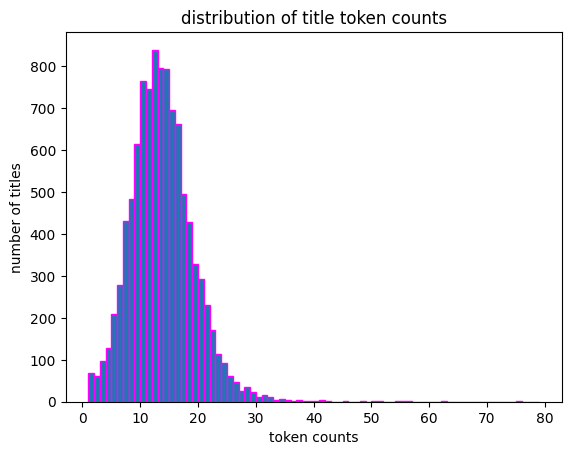

In [7]:
df_data_title_max = df_data_title['token_count'].idxmax()
print(Fore.CYAN + f"max title: \n{df_data_title['title'][df_data_title_max]}") 

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

title_lengths = df_data_title['token_count']

plt.hist(df_data_title['token_count'], bins=range(1, 80), edgecolor='magenta')

plt.title('distribution of title token counts')
plt.xlabel('token counts')
plt.ylabel('number of titles')

plt.show()

- [ ] abstract:
    - count of tokens, stop words, punctuation, special char, formatting char, numerals, non-text elements
    - descriptive analysis

In [8]:
# abstract analysis
#create list of special formatting phrases,tokens,chars found in abstracts
# maybe use regex such as '[<*>]'? ref: https://stackoverflow.com/questions/7206499/match-letter-in-any-language

regex_pattern = "<.*?>|\\n"

#create abstract specific datarame
df_data_abstract = df_data[['type','DOI','abstract']]

matched_patterns = df_data_abstract['abstract'].str.findall(regex_pattern)
df_data_abstract['matched_patterns'] = matched_patterns

def count_patterns_matched(x:list)->int:
    return len(x)

df_data_abstract['num_pattern_matched'] = df_data_abstract['matched_patterns'].apply(count_patterns_matched)


#count tokens in abstract prior to identifying pattern
def count_tokens(x:str)->int:
    "counts the number of tokens in a title or abstract"
    token_list=(x.split(sep=" "))
    return len(token_list)

df_data_abstract.loc[:,'token_count'] = df_data_abstract['abstract'].apply(count_tokens)
    
#check for numerals
df_data_abstract.loc[:,'numeral_count'] = df_data_abstract['abstract'].apply(check_for_numerals)

# count stopwords
#count_stopwords()
df_data_abstract.loc[:,'stopword_count'] = df_data_abstract['abstract'].apply(count_stopwords)

#punctuation count
punct_pattern = "[!@#$%&*()?;:'\"]"
punct_patterns = df_data_abstract['abstract'].str.findall(punct_pattern)
df_data_abstract['punctuation_patterns'] = punct_patterns
df_data_abstract.loc[:,'punctuation_count'] = df_data_abstract['punctuation_patterns'].apply(lambda x: len(x))

# calculate percentage based of len(abstract)

In [9]:
# create the table I need for abstract analysis
# abstract | count tokens | stopwords | punctuation | formatting tokens | numerals 
def percent_calc(x:int)->float:
    percent = x/len(df_data_abstract['abstract'])*100
    return percent
print(df_data_abstract.columns)
df_data_abstract_grouped = df_data_abstract.groupby('type')[['token_count',
                    'num_pattern_matched',
                    'stopword_count',
                    'punctuation_count',
                    'numeral_count']].agg(['mean','median','max','min'])

df_data_abstract_grouped





Index(['type', 'DOI', 'abstract', 'matched_patterns', 'num_pattern_matched',
       'token_count', 'numeral_count', 'stopword_count',
       'punctuation_patterns', 'punctuation_count'],
      dtype='object')


token_count                  num_pattern_matched  \
                                mean median   max min                mean   
type                                                                        
book-chapter:None         143.770000  140.0   609   1            3.380000   
journal-article:None      217.697083  198.0  2830   1            9.409792   
proceedings-article:None  182.285000  152.5   827  17            3.815000   

                                         stopword_count                  \
                         median  max min           mean median  max min   
type                                                                      
book-chapter:None           2.0   42   1      46.003333   46.5  156   0   
journal-article:None        2.0  706   1      56.845729   59.0  435   0   
proceedings-article:None    2.0   42   2      51.495000   40.0  286   0   

                         punctuation_count                 numeral_count  \
                                      mean median  max min          mean   
type                                                                       
book-chapter:None                  5.19000    4.0   33   0      3.023333   
journal-article:None              17.92375    8.0  740   0     18.215000   
proceedings-article:None           8.43000    4.0   88   2      7.270000   

                                          
                         median  max min  
type                                      
book-chapter:None           0.0   51   0  
journal-article:None        7.0  612   0  
proceedings-article:None    2.0   96   0

In [74]:
df_data_abstract_grouped.to_excel("tables/table_7.xlsx")

Index(['type', 'DOI', 'abstract', 'matched_patterns', 'num_pattern_matched',
       'token_count', 'numeral_count', 'stopword_count',
       'punctuation_patterns', 'punctuation_count'],
      dtype='object')


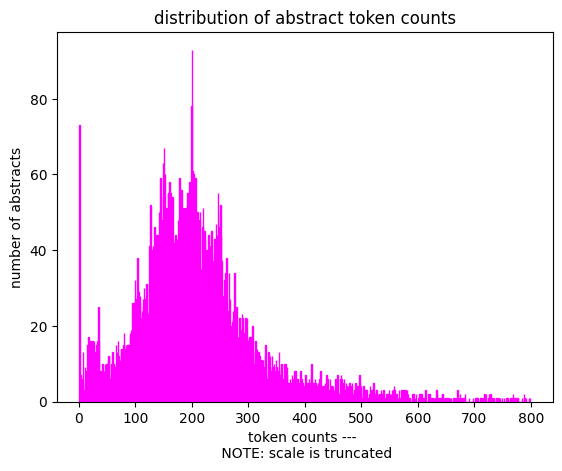

In [75]:
print(df_data_abstract.columns)

#df_data_abstract_max = df_data_abstract['token_count'].idxmax()
#print(Fore.CYAN + f"max abstract: \n{df_data_abstract['abstract'][df_data_abstract_max]}") 

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

abstract_lengths = df_data_abstract['token_count']

plt.hist(df_data_abstract['token_count'], bins=range(1, 800), edgecolor='magenta')

plt.title('distribution of abstract token counts')
plt.xlabel('token counts --- \n NOTE: scale is truncated')
plt.ylabel('number of abstracts')

plt.show()

# title and abstract subset analysis
- [ ] Title and abstract
    - subset used for screening error types:
        - contains both languages  
        - language not consistent with language attribute 
        - duplicate characters  
        - NA for title  
        - all caps  
        - includes web address  
        - includes conference location name, date  
        - inclusion of HTML text formatting codes/face markup  
        - inclusion of numbers or characters not in title  
        - includes full citation  
        - includes isbn  
        - nonsense title/placeholder  
        - includes author 
    - applied to rest of sample for counts
    - coded for inconsistent value rep    


In [84]:
# title and abstract subset analysis
# *********** NEED TO DETERMINE SUBSET QUANTITY ***********
# starting with 300, 200 JA, 50 BC, and 50 PA
df_title_subset = df_data[['type','DOI','title']]
df_title_subset['len_title'] = df_title_subset['title'].apply(lambda x:len(x))
df_title_subset_ja = df_title_subset[df_title_subset['type']=='journal-article:None']
df_title_subset_bc = df_title_subset[df_title_subset['type']=='book-chapter:None']
df_title_subset_pro = df_title_subset[df_title_subset['type']=='proceedings-article:None']

In [239]:
#subset for abstracts
df_abstract_subset = df_data[['type','DOI','abstract']]
#create new col with length of abstract
df_abstract_subset['len_abstract'] = df_abstract_subset['abstract'].apply(lambda x: len(x))
#create subset based on type
df_abstract_subset_ja = df_abstract_subset[df_abstract_subset['type']=='journal-article:None']
df_abstract_subset_bc = df_abstract_subset[df_abstract_subset['type']=='book-chapter:None']
df_abstract_subset_pro = df_abstract_subset[df_abstract_subset['type']=='proceedings-article:None']

df_abstract_subset_ja_largest = df_abstract_subset_ja.nlargest(100,'len_abstract')
df_abstract_subset_ja_smallest = df_abstract_subset_ja.nsmallest(100,'len_abstract')
df_abstract_subset_ja = pd.concat([df_abstract_subset_ja_largest,df_abstract_subset_ja_smallest])

df_abstract_subset_bc_largest = df_abstract_subset_bc.nlargest(25,'len_abstract')
df_abstract_subset_bc_smallest = df_abstract_subset_bc.nsmallest(25,'len_abstract')
df_abstract_subset_bc = pd.concat([df_abstract_subset_bc_largest,df_abstract_subset_bc_smallest])

df_abstract_subset_pro_largest = df_abstract_subset_pro.nlargest(25,'len_abstract')
df_abstract_subset_pro_smallest = df_abstract_subset_pro.nsmallest(25,'len_abstract')
df_abstract_subset_pro = pd.concat([df_abstract_subset_pro_largest,df_abstract_subset_pro_smallest])

print(Fore.MAGENTA + f"len df_abstract_subset_ja: {len(df_abstract_subset_ja)}")
print(Fore.CYAN + f"len df_abstract_subset_bc: {len(df_abstract_subset_bc)}")
print(Fore.YELLOW + f"len df_abstract_subset_pro: {len(df_abstract_subset_pro)}"+Style.RESET_ALL)

df_abstract_subset = pd.concat([df_abstract_subset_ja, df_abstract_subset_bc, df_abstract_subset_pro])

df_abstract_subset = df_abstract_subset.reset_index(drop=True, level=1)
df_abstract_subset = df_abstract_subset.reset_index(drop=True)
df_abstract_subset.to_excel('data/part_1_df_abstract_subset.xlsx')


len df_abstract_subset_ja: 200
len df_abstract_subset_bc: 50
len df_abstract_subset_pro: 50


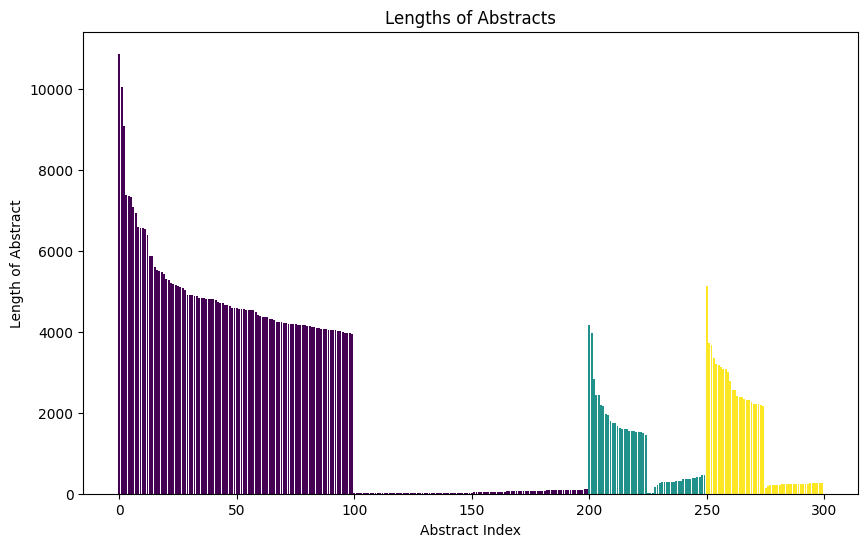

In [252]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df_abstract_subset_ja.reset_index(drop=True, inplace=True)

# Define a colormap
cmap = cm.get_cmap('viridis', len(df_abstract_subset['type'].unique()))
colors = {t: cmap(i) for i, t in enumerate(df_abstract_subset['type'].unique())}

# Plot the bar chart
plt.figure(figsize=(10, 6))
for i, row in df_abstract_subset.iterrows():
    plt.bar(i, row['len_abstract'], color=colors[row['type']])

plt.xlabel('Abstract Index')
plt.ylabel('Length of Abstract')
plt.title('Lengths of Abstracts')
plt.show()




In [85]:
df_title_subset_ja_largest = df_title_subset_ja.nlargest(100,'len_title')
df_title_subset_ja_smallest = df_title_subset_ja.nsmallest(100,'len_title')
df_title_subset_ja = pd.concat([df_title_subset_ja_largest,df_title_subset_ja_smallest])

df_title_subset_bc_largest = df_title_subset_bc.nlargest(25,'len_title')
df_title_subset_bc_smallest = df_title_subset_bc.nsmallest(25,'len_title')
df_title_subset_bc = pd.concat([df_title_subset_bc_largest,df_title_subset_bc_smallest])

df_title_subset_pro_largest = df_title_subset_pro.nlargest(25,'len_title')
df_title_subset_pro_smallest = df_title_subset_pro.nsmallest(25,'len_title')
df_title_subset_pro = pd.concat([df_title_subset_pro_largest,df_title_subset_pro_smallest])

In [86]:
print(Fore.LIGHTBLUE_EX + f"len df_title_subset_ja: {len(df_title_subset_ja)}")
print(Fore.LIGHTGREEN_EX + f"len df_title_subset_bc: {len(df_title_subset_bc)}")
print(Fore.LIGHTYELLOW_EX + f"len df_title_subset_pro: {len(df_title_subset_pro)}")

df_title_subset = pd.concat([df_title_subset_ja,df_title_subset_bc,df_title_subset_pro])

len df_title_subset_ja: 200
len df_title_subset_bc: 50
len df_title_subset_pro: 50


In [87]:

df_title_subset = df_title_subset.reset_index(drop=True, level=1)
df_title_subset = df_title_subset.reset_index(drop=True)


In [93]:

df_title_subset.loc[0,'crossref_title_count'] = 3


In [95]:
df_title_subset.to_excel('data/part_1_df_title_subset.xlsx')

# subset analysis
## title subset analysis
- I opened each DOI, checking its XML Crossref data and the landing page. If a PDF was available as OA or as part of DAlhousie's subscription, I checked the PDF. I did not check other file formats, such as HTML or XML versions of the final work. 
- The following were recorded:
    - crossref_title_count: how many title elements were there regardless if they were duplicated
    - subtitle count: if subtitle elements were used; Yes/No
    - orig_lang_title: if original_language_title element was used: Yes/No
    - facemarkup: if face markup langugage was used in title or subtitle, but no distiction between the two. 
    - language_metadata: if there was any language attribute in the journal_article, content_item for book-chapters, or conference_paper for proceedings-articles container element attributes, title, subtitle, or original_language_title elements
    - matches_landing_page: if the title recorded matches what the publisher has on the landing page for that work
    - problem: records any problems between the title from the REST API and what is found on the landing page or the PDF of the work. 
    - all_caps: if the title uses all capitals instead of title or sentence case.
        - If the original article had the title in two languages, but only one was in the metadata, I recorded "Original language article, translated title in article". 
        - If the metadata did not match one or more titles in the landing page or PDF, then "incorrect title metadata"
        - If the article was in one language and the metadata in another, then "Original language article, translated metadata"
        - if the title was correct, but some other error, such as all caps were used, then "Correct title; all caps"
        - if face markup was included in the REST or XML metadata, but is rendering correctly in the landing page or PDF, then "includes MATH ML face markup" or similar, such as "includes face markup"
        - if multiple languages found in title, then "Two Languges in title"
        - if a bad URL, then "can't verify"
        - responses recorded can also be combined separated by a ";"
    - Notes: any extraordinary errors that need to be clarified. Optional and not completed for all rows. 

In [158]:
df_title_subset_collected = pd.read_excel("data/part_1_df_title_subset.xlsx")
df_title_subset_collected.drop(columns="Unnamed: 0", inplace=True)
df_title_subset_collected['crossref_title_count'] = df_title_subset_collected['crossref_title_count'].astype('int')

In [159]:
def percent_calc(x:int)->float:
    percent = x/len(df_title_subset_collected)*100
    return percent


In [160]:
cross_title_count_count = pd.DataFrame(df_title_subset_collected.groupby(['type','crossref_title_count'])['crossref_title_count'].count())
print(Fore.LIGHTCYAN_EX + f"Count of title elements in Crossref XML metadata: \n{cross_title_count_count}")


Count of title elements in Crossref XML metadata: 
                                               crossref_title_count
type                     crossref_title_count                      
book-chapter:None        1                                       50
journal-article:None     0                                        2
                         1                                      191
                         2                                        6
                         3                                        1
proceedings-article:None 1                                       49
                         2                                        1


In [161]:
cross_title_others = pd.DataFrame(df_title_subset_collected.groupby(['type','subtitle'])[['subtitle']].count())
cross_title_others['percent'] = cross_title_others['subtitle'].transform(percent_calc) # cool, but this is the percent of the whole subset
cross_title_others

subtitle    percent
type                     subtitle                     
book-chapter:None        No              39  13.000000
                         Yes             11   3.666667
journal-article:None     No             183  61.000000
                         Yes             17   5.666667
proceedings-article:None No              50  16.666667

In [162]:
cross_title_face = pd.DataFrame(df_title_subset_collected.groupby(['type','facemarkup'])['facemarkup'].count())
cross_title_face

facemarkup
type                     facemarkup            
book-chapter:None        No                  50
journal-article:None     No                 173
                         Yes                 27
proceedings-article:None No                  50

In [163]:
cross_title_lang = pd.DataFrame(df_title_subset_collected.groupby(['type','original_lang_title'])[['original_lang_title','language_metadata']].count())
cross_title_lang

original_lang_title  \
type                     original_lang_title                        
book-chapter:None        No                                    41   
                         Yes                                    9   
journal-article:None     No                                   194   
                         Yes                                    6   
proceedings-article:None No                                    45   
                         Yes                                    5   

                                              language_metadata  
type                     original_lang_title                     
book-chapter:None        No                                   0  
                         Yes                                  7  
journal-article:None     No                                  19  
                         Yes                                  1  
proceedings-article:None No                                   2  
                         Yes                                  2

In [164]:
cross_title_matches = pd.DataFrame(df_title_subset_collected.groupby(['type', 'matches_landing_page'])[['matches_landing_page']].count())
cross_title_matches

matches_landing_page
type                     matches_landing_page                      
book-chapter:None        Not Available                            8
                         Yes                                     42
journal-article:None     No                                      26
                         Not Available                           15
                         Yes                                    159
proceedings-article:None No                                       2
                         Not Available                           10
                         Yes                                     38

In [165]:
#matches PDF
cross_title_PDF = pd.DataFrame(df_title_subset_collected.groupby(['type', 'matches_PDF'])['matches_PDF'].count())
cross_title_PDF

matches_PDF
type                     matches_PDF               
book-chapter:None        Not Available           31
                         Yes                     19
journal-article:None     No                      46
                         Not Available           34
                         Yes                    120
proceedings-article:None No                       7
                         Not Available           18
                         Yes                     25

In [166]:
cross_title_all_caps = pd.DataFrame(df_title_subset_collected.groupby(['type','all_caps'])['all_caps'].count())
cross_title_all_caps.to_excel('tables/table_20.xlsx')
cross_title_all_caps

all_caps
type                     all_caps          
book-chapter:None        No              46
                         Yes              4
journal-article:None     No             191
                         Yes              9
proceedings-article:None No              44
                         Yes              6

In [167]:
#problems analysis
cross_title_problem = pd.DataFrame(df_title_subset_collected.groupby(['type','problem'])['problem'].count())
cross_title_problem.to_excel("tables/table_20.xlsx")
cross_title_problem

problem
type                     problem                                                        
book-chapter:None        Can't verify                                                  4
                         Correct title                                                45
                         Original language article; translated metadata                1
journal-article:None     Can't verify                                                  6
                         Correct title                                               133
                         Original language article; translated metadata                6
                         Original language article; translated title in article       20
                         includes face markup                                         12
                         includes face markup                                          1
                         incorrect title metadata                                     14
                         two Languages in <title>                                      8
proceedings-article:None Can't verify                                                  2
                         Correct title                                                39
                         Original language article; translated metadata                1
                         Original language article; translated title in article        5
                         incorrect title metadata                                      3

<positron-console-cell-169>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-169>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<positron-console-cell-169>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

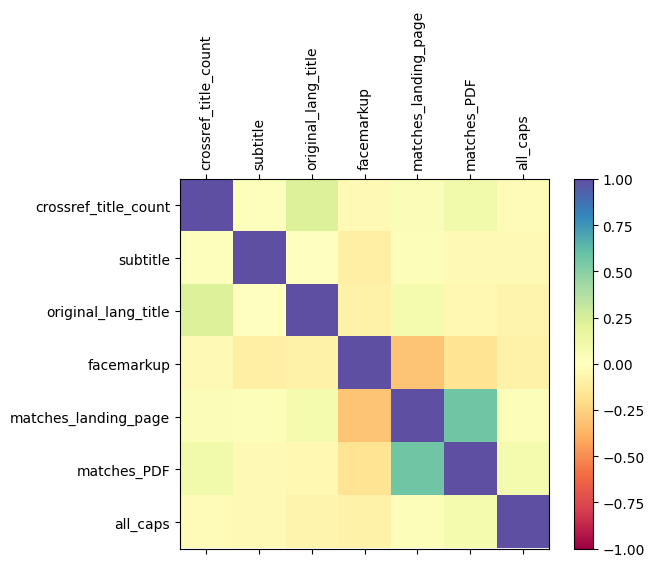

In [169]:
#correlation
# ref:https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
# ref:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
import matplotlib.pyplot as plt
#need to convert any str to int, replace No:0, yes:1


data = df_title_subset_collected[['crossref_title_count','subtitle','original_lang_title', 'facemarkup', 'matches_landing_page', 'matches_PDF','all_caps']]

data['subtitle'].replace({'Yes':1,'No':0}, inplace=True)
data['original_lang_title'].replace({'Yes':1,'No':0}, inplace=True)
data['facemarkup'].replace({'Yes':1,'No':0}, inplace=True)
data['matches_landing_page'].replace({'Yes':1,'No':0, 'Not Available':np.nan}, inplace=True)
data['matches_PDF'].replace({'Yes':1,'No':0, 'Not Available':np.nan}, inplace=True)
data['all_caps'].replace({'Yes':1,'No':0}, inplace=True)
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='Spectral', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()


<positron-console-cell-173>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-173>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-173>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To 

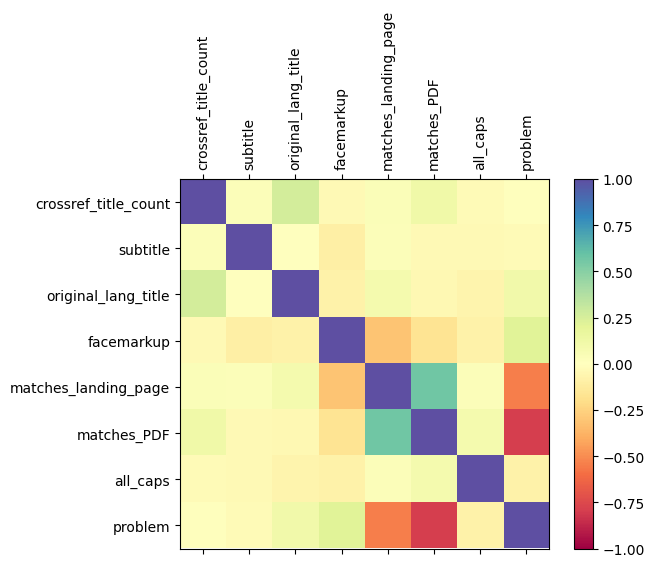

In [173]:
# try it now with spearman correlation and including nominal values for 'problem'
data = df_title_subset_collected[['crossref_title_count','subtitle','original_lang_title', 'facemarkup', 'matches_landing_page', 'matches_PDF','all_caps','problem']]
data['problem'] = data['problem'].apply(lambda x: str.rstrip(x))

data['subtitle'].replace({'Yes':1,'No':0}, inplace=True)
data['original_lang_title'].replace({'Yes':1,'No':0}, inplace=True)
data['facemarkup'].replace({'Yes':1,'No':0}, inplace=True)
data['matches_landing_page'].replace({'Yes':1,'No':0, 'Not Available':np.nan}, inplace=True)
data['matches_PDF'].replace({'Yes':1,'No':0, 'Not Available':np.nan}, inplace=True)
data['all_caps'].replace({'Yes':1,'No':0}, inplace=True)
data['problem'].replace({"Can't verify":1,
                        'Correct title':0,
                        'Original language article; translated metadata':2,
                        'Original language article; translated title in article':3,
                        'includes face markup':4,
                        'incorrect title metadata':5,
                        'two Languages in <title>':6}, inplace=True)
corr = data.corr(method='spearman')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='Spectral', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

## citedby_count
- line chart or histogram
- by doc-type and other interesting intersections

                              mean  median  max  min
type                                                
book-chapter:None         0.456667     0.0   34    0
journal-article:None      4.250000     0.0  505    0
proceedings-article:None  0.410000     0.0   10    0
Index(['type', 'DOI', 'cited_by', 'rank'], dtype='object')


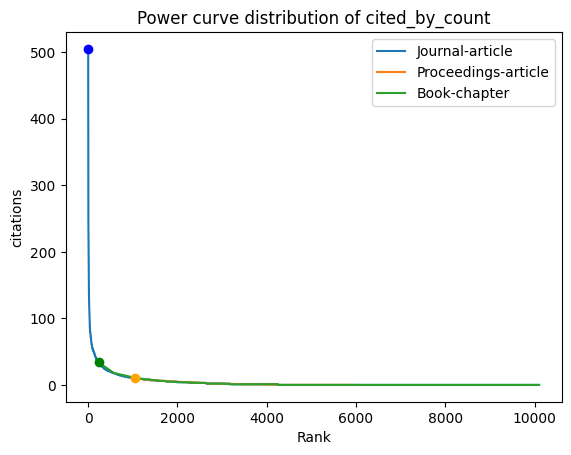

In [110]:
# cited by count

df_data_citedby = df_data[['type','DOI','cited_by']]
df_data_citedby = df_data_citedby.sort_values(by='cited_by', ascending=False)

print(f"{pd.DataFrame(df_data_citedby.groupby('type')['cited_by'].agg(['mean','median','max','min']))}")

#export as table 8
pd.DataFrame(df_data_citedby.groupby('type')['cited_by'].agg(['mean','median','max','min'])).to_excel("tables/table_8.xlsx")

df_data_citedby['rank'] = range(1, len(df_data_citedby) + 1)
print(df_data_citedby.columns)

df_data_citedby_grp = df_data_citedby.groupby('type')[['rank','cited_by','DOI']]
#create a subgroup for each type
df_data_citedby_bc = df_data_citedby_grp.get_group('book-chapter:None')
df_data_citedby_ja = df_data_citedby_grp.get_group('journal-article:None')
df_data_citedby_pa = df_data_citedby_grp.get_group('proceedings-article:None')

#plot each type

plt.plot(df_data_citedby_ja['rank'], df_data_citedby_ja['cited_by'], label='Journal-article')
plt.plot(df_data_citedby_pa['rank'], df_data_citedby_pa['cited_by'], label = 'Proceedings-article')
plt.plot(df_data_citedby_bc['rank'], df_data_citedby_bc['cited_by'], label = 'Book-chapter')

# put a marker on the highest citation
plt.plot(df_data_citedby_ja[df_data_citedby_ja['cited_by'] == df_data_citedby_ja['cited_by'].max()]['rank'], df_data_citedby_ja[df_data_citedby_ja['cited_by'] == df_data_citedby_ja['cited_by'].max()]['cited_by'], marker='o', color='blue')
plt.plot(df_data_citedby_pa[df_data_citedby_pa['cited_by'] == df_data_citedby_pa['cited_by'].max()]['rank'], df_data_citedby_pa[df_data_citedby_pa['cited_by'] == df_data_citedby_pa['cited_by'].max()]['cited_by'], marker='o', color='orange')
plt.plot(df_data_citedby_bc[df_data_citedby_bc['cited_by'] == df_data_citedby_bc['cited_by'].max()]['rank'], df_data_citedby_bc[df_data_citedby_bc['cited_by'] == df_data_citedby_bc['cited_by'].max()]['cited_by'], marker='o', color='green')

plt.xlabel('Rank')
plt.ylabel('citations')
plt.title('Power curve distribution of cited_by_count')
plt.legend()
plt.show()



# license analysis
- [ ] license version and url/type
    - type ,count, %, common or proprietary 


In [184]:
# license version and url by type
print(df_data.columns)
df_data_license = df_data[['type','DOI','license_version','license_type']]

# strip '/' from end of licenses
#df_data_license['license_type'] = df_data_license['license_type'].apply(lambda x: x.rstrip("/") if isinstance(x, str) else x)

# strip '/' from end of licenses and remove second address if present
df_data_license['license_type'] = df_data_license['license_type'].apply(lambda x: x.split(' ')[0].rstrip("/") if isinstance(x, str) else x)

print(Fore.LIGHTCYAN_EX + f"\n-----\n{df_data_license.groupby(['type','license_version'])['license_type'].count()}")
df_data_license.groupby(['type','license_version'])['license_type'].count().to_excel('tables/table_10.xlsx')

df_data_license_2 = pd.DataFrame(df_data_license.groupby(['type']).agg({'DOI':'count','license_version':'count'}))
df_data_license_2.loc[:,'percentage'] = df_data_license_2['license_version']/df_data_license_2['DOI']*100
df_data_license_2.to_excel('tables/table_9.xlsx')
df_data_license_2

# **** some cleanup is needed to reduce duplicates ****

#handling nans
df_data_license['license_type'] = df_data_license['license_type'].fillna('')
#replace http in creative commons
df_data_license['license_type'] = df_data_license['license_type'].apply(lambda x: x.replace("http://creativecommons.org/","https://creativecommons.org/"))


def replace_last(x:str)->str:
    #removes suffixes from web addresses
    suffix_list = ["/igo","/legalcode","deed.es","/in","/deed.es","/deed.en","/deed.it","/deed.pt-br","/deed.pt_BR","/legalcode","/legalcode.cs","/br","/deed.uk","/es","/deed.id","/deed.en_US","/?ref=chooser-v1","/deed.de","/deed.en","/deed.en_GB","/deed.pt_BR","/deed.ru","/legalcode"]
    for i in suffix_list:
        x = x.rstrip().removesuffix(i)
        x = x.removesuffix("/")
    return x
test = "https://creativecommons.org/licenses/by-nc-sa/4.0/deed.uk  "
print(Fore.RED + f"{replace_last(test)}")
df_data_license['license_type'] = df_data_license['license_type'].apply(replace_last)

print(Fore.LIGHTYELLOW_EX + f"\nCount by license type ------\n{df_data_license.groupby(['type','license_type'])['license_type'].count()}")


Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url',
       'license_version', 'license_type'],
      dtype='object')

-----
type                      license_version
book-chapter:None         unspecified          45
                          vor                  25
journal-article:None      unspecified        2219
                          vor                3598
proceedings-article:None  vor                  22
Name: license_type, dtype: int64
https://creativecommons.org/licenses/by-nc-sa/4.0

Count by license type ------
type                      license_type                                                                                                                                                 
book-chapter:None                                                                                                                                                                           230
                          https://creativecommons.org/licenses/CC/by-nc-n

<positron-console-cell-184>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-184>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-184>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-184>:36: SettingWi

In [185]:
# remove "http(s)://creativecommons.org/licenses/" from the url for type
# or leave it and use it to identify those that are public licenses and those that are proprietary

pattern = [("http://creativecommons.org/licenses/","https://creativecommons.org/licenses/")]

#.find() returns the index, -1 if it doesn't find anything
#.contains() returns a boolean

def open_or_proprietary(x: str) -> str:
    for j, k in pattern:
        if x:
            if x.find(j) != -1 or x.find(k) != -1:
                return 'creative commons'
            else:
                return 'proprietary'
        return None
# Replace NaN values with an empty string
df_data_license['license_type'].fillna('', inplace=True)

df_data_license.loc[:, 'open_or_proprietary'] = df_data_license['license_type'].apply(open_or_proprietary)
print(Fore.LIGHTGREEN_EX + f"{df_data_license.groupby(['type','open_or_proprietary'])['open_or_proprietary'].count()}")
df_data_license.groupby(['type','open_or_proprietary'])['open_or_proprietary'].count().to_excel('tables/table_11.xlsx')
#let's just see the creative commons ones
df_filtered = df_data_license.groupby(['type','license_type'])['license_type'].apply(lambda x: x[x.str.startswith("https://creativecommons.org/")].count()).reset_index(name='count')
#print(Fore.LIGHTCYAN_EX + f"\nGrouped by type and license_type:\n{df_data_license.groupby(['type','license_type'])['license_type'].count()}")

df_filtered = df_filtered[df_filtered['count']>0].sort_values(by='count', ascending=False)
df_filtered = df_filtered.groupby(['type','license_type','count']).count()

df_filtered.to_excel('tables/table_12.xlsx')
df_filtered

type                      open_or_proprietary
book-chapter:None         creative commons         67
                          proprietary               3
journal-article:None      creative commons       4847
                          proprietary             970
proceedings-article:None  proprietary              22
Name: open_or_proprietary, dtype: int64


<positron-console-cell-185>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-185>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-185>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Empty DataFrame
Columns: []
Index: [(book-chapter:None, https://creativecommons.org/licenses/CC/by-nc-nd/4.0, 1), (book-chapter:None, https://creativecommons.org/licenses/by-nc-nd/4.0, 2), (book-chapter:None, https://creativecommons.org/licenses/by-nc/4.0, 12), (book-chapter:None, https://creativecommons.org/licenses/by/3.0, 26), (book-chapter:None, https://creativecommons.org/licenses/by/4.0, 26), (journal-article:None, https://creativecommons.org/licenses, 2), (journal-article:None, https://creativecommons.org/licenses/7by-nc-sa/4.0, 1), (journal-article:None, https://creativecommons.org/licenses/BY-SA/4.0, 2), (journal-article:None, https://creativecommons.org/licenses/BY/4.0, 1), (journal-article:None, https://creativecommons.org/licenses/authors, 1), (journal-article:None, https://creativecommons.org/licenses/bv/4.0, 1), (journal-article:None, https://creativecommons.org/licenses/by-nc-nd/2.5, 3), (journal-article:None, https://creativecommons.org/licenses/by-nc-nd/3.0, 17), (journal-article:None, https://creativecommons.org/licenses/by-nc-nd/4.0, 441), (journal-article:None, https://creativecommons.org/licenses/by-nc-sa/3.0, 1), (journal-article:None, https://creativecommons.org/licenses/by-nc-sa/4.0, 231), (journal-article:None, https://creativecommons.org/licenses/by-nc/3.0, 22), (journal-article:None, https://creativecommons.org/licenses/by-nc/4.0, 449), (journal-article:None, https://creativecommons.org/licenses/by-nd/4.0, 21), (journal-article:None, https://creativecommons.org/licenses/by-sa/3.0, 2), (journal-article:None, https://creativecommons.org/licenses/by-sa/4.0, 334), (journal-article:None, https://creativecommons.org/licenses/by/3.0, 172), (journal-article:None, https://creativecommons.org/licenses/by/4.0, 3148), (journal-article:None, https://creativecommons.org/publicdomain/zero/1.0, 6), (journal-article:None, https://creativecommons.org/share-your-work/public-domain/cc0, 2)]

## license subset analysis
- [ ] License - identification of locations, difference between REST and XML API?
- types:
    - [ ] errors in consistency, conventions such as with CC-BY, etc. 
    - [ ] coded for incorrect values, missing info, and inconsistent value rep
    - [ ] sample of types that are non-CC

In [29]:
# ****** Still need to do this *******
# many errors and need to identify which others are open besides CC

- [ ] language
    - type, count of each type, % in abstract, % in journal level attribution

Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url',
       'license_version', 'license_type'],
      dtype='object')
type                  language
book-chapter:None     de             4
                      en           171
                      fr             3
                      ng             3
                      no             2
                      pt             2
                      tr             1
journal-article:None  ar             3
                      az             1
                      bg             2
                      cs             2
                      de            35
                      en          4530
                      es            21
                      et             2
                      fr            13
                      hr             1
                      hy             2
                      id             1
                      it             3
                      ja             2
           

<positron-console-cell-190>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-190>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


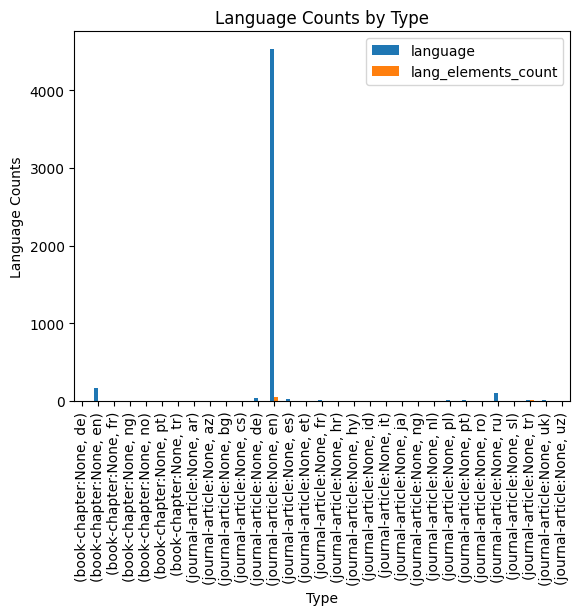

In [190]:
import re
# language
print(df_data.columns)
df_data_language = df_data[["type",'DOI','language','abstract']]
print(Fore.LIGHTMAGENTA_EX + f"{df_data_language.groupby(['type','language'])['language'].count()}")

pattern = 'xml:lang=\".+?\"'

def find_lang(x:str)->list:
    # Find all elements with the attribute lang
    lang_elements = re.findall(pattern, x)
    if lang_elements:
        return lang_elements
    else:
        return []

#test_string = ' some test text, xml:lang="pt"'

#print(find_lang(test_string))

df_data_language.loc[:,'lang_elements'] = df_data_language['abstract'].apply(find_lang)
df_data_language.loc[:,'lang_elements_count'] = df_data_language['lang_elements'].apply(lambda x: len(x))

print(Fore.LIGHTBLUE_EX+ f"\n-----Count of languages and lang= elements in abstract, if any:------\n{df_data_language.groupby(['type','language']).agg({'language':'count','lang_elements_count':'sum'})}")
df_data_language.groupby(['type','language']).agg({'language':'count','lang_elements_count':'sum'}).to_excel('tables/table_13.xlsx')
df_data_langauge_grp = df_data_language.groupby(['type','language']).agg({'language':'count','lang_elements_count':'sum'})



# Abstract Subset post-data collection analysis
## Data collection
- I opened each DOI in the Crossref XML API call, the REST API, the landing page using a resolver, through our institutional library access. 
- Each abstract was pasted from the Excel document into Sublime Text to look for face markup, non-latin characters, language attributes, or other issues, such as mixed languages. 
- The following items were recorded and notes on their source
    - facemarkup: I looked for this in the plain text as well as in the XML API call. Value of Yes or No was recorded
    - language_metadata: I looked for jats language attributes by searching for 'lang=' in the plain text. I also looked for an attribute in the top level abstract container in the XML API call. If in either place, I recorded the ISO value(s) such as "en" or "de","en". If no attribute, I recorded 'No'.
    - matches_landing_page: Value of Yes, No, or Not Available. Yes if the content matched the abstract content completely on the landing page. No, if there was any discrepancy, missing language version, truncation, or missing from the landing page. Not Available if the resolver and DOI failed to connect or was directed to a different resource. 
    - matches_PDF: Yes, No, or Not Available. Yes if the PDF content matched the abstract content completely. No, if there was any discrepancy, missing language version in the PDF, truncation, or missing from the PDF. Not Available if the DOI resolver, the link from the landing page, or my institutional access could not find a PDF resource. 
    - all_caps: Yes if the abstract was in all capitals. No, if it was in sentence case, or in non-latin character set, such as Cyrillic, CKJ or Arabic. 
    - XML_and_REST_agreement: Yes if the abstract contents were the same between the two sources. No if there was a difference, such as missing a second abstract container for another language version. (typical as REST only retrieves the first container if there are multiple containers.)
    - problem: brief description of problem identified, usually as justification for one of the above. Non-latin characters, inclusion of MathML, including hyperlinks, or including 2 languages would be typical problems. 
    - notes: additional information to help expand upon the problem above where I chose a generic statement. Example, problem might be 'includes 2 languages' and notes would expand on which languages and if these were found in the PDF or on the landing page, or were absent from one but included in the other. 

In [205]:
# import data
abstract_subset_complete = pd.read_excel("data/part_1_df_abstract_subset.xlsx")


In [195]:
facemarkup = pd.DataFrame(abstract_subset_complete.groupby(['type', 'facemarkup'])['facemarkup'].count())
facemarkup.to_excel("tables/abstract_facemarkup.xlsx")
facemarkup

facemarkup
type                     facemarkup            
book-chapter:None        No                  50
journal-article:None     MathML              13
                         No                 185
                         tex-math             2
proceedings-article:None HTML                 1
                         No                  49

In [204]:
facemarkup_yes_problem = abstract_subset_complete[abstract_subset_complete['facemarkup']!='No']
facemarkup_yes_problem = pd.DataFrame(facemarkup_yes_problem.groupby(['type','problem'])['problem'].count())
facemarkup_yes_problem.to_excel("tables/abstract_facemarkup_yes_problem.xlsx")
facemarkup_yes_problem

problem
type                     problem                                       
journal-article:None     MathML                                       8
                         MathML; includes copyright statement         1
                         U+2009 thin space from general punc;         2
                         includes HTML                                1
                         includes disclosures; includes figure        1
                         includes hyperlinks                          1
                         includes tex-math, not MathML                1
proceedings-article:None includes HTML                                1

In [206]:
abstract_language = pd.DataFrame(abstract_subset_complete.groupby(['type','language_metadata'])[['language_metadata']].count())
abstract_language_no = abstract_subset_complete[abstract_subset_complete['language_metadata']=='No']
abstract_language_no = pd.DataFrame(abstract_language_no.groupby(['type','language_metadata'])['language_metadata'].count())
abstract_language_no.to_excel("tables/abstract_language_no.xlsx")
print(f"abstract_language_no: \n{abstract_language_no}")

abstract_language_yes = abstract_subset_complete[abstract_subset_complete['language_metadata']!='No']
abstract_language_yes = pd.DataFrame(abstract_language_yes.groupby(['type','language_metadata'])['language_metadata'].count())
abstract_language_yes.to_excel("tables/abstract_language_yes.xlsx")
print(f"**************\nabstract_language_yes: \n{abstract_language_yes}")

abstract_language_no: 
                                            language_metadata
type                     language_metadata                   
book-chapter:None        No                                35
journal-article:None     No                               161
proceedings-article:None No                                36
**************
abstract_language_yes: 
                                                        language_metadata
type                     language_metadata                               
book-chapter:None        "en"                                           8
                         "es"                                           4
                         "pt"                                           3
journal-article:None     "ar"                                           1
                         "ar","en"                                      1
                         "de"                                           1
                         "de","en"  

In [211]:
matches = abstract_subset_complete[['matches_landing_page','matches_PDF','DOI']]

matches = pd.pivot_table(matches, index=['matches_landing_page'], columns=['matches_PDF'], aggfunc="count")
matches.to_excel('tables/abstract_matches.xlsx')
print(Fore.LIGHTCYAN_EX+ f"matrix of matches_landing_page and matches_PDF:\n{matches}"+Style.RESET_ALL)

matches_lp = abstract_subset_complete[['type','matches_landing_page','matches_PDF','DOI']]
matches_lp = pd.DataFrame(matches_lp.groupby(['type','matches_landing_page'])['DOI'].count())
print(Fore.LIGHTMAGENTA_EX+f"\n***************\ngrouped by type and matches_landing_page counts: \n{matches_lp}")
matches_lp.to_excel('tables/abstract_matches_lp.xlsx')

matches_pdf = abstract_subset_complete[['type','matches_landing_page','matches_PDF','DOI']]
matches_pdf = pd.DataFrame(matches_pdf.groupby(['type','matches_PDF'])['DOI'].count())
print(Fore.LIGHTYELLOW_EX+f"\n**************\ngrouped by type and matches_pdf: \n{matches_pdf}")
matches_pdf.to_excel('tables/abstract_matches_pdf.xlsx')


matrix of matches_landing_page and matches_PDF:
                     DOI                   
matches_PDF           No Not available  Yes
matches_landing_page                       
No                    14             7    8
Not available          4            11   12
Yes                   19            81  144

***************
grouped by type and matches_landing_page counts: 
                                               DOI
type                     matches_landing_page     
book-chapter:None        No                      6
                         Not available           7
                         Yes                    37
journal-article:None     No                     21
                         Not available          15
                         Yes                   164
proceedings-article:None No                      2
                         Not available           5
                         Yes                    43

**************
grouped by type and matches_pdf: 
          

In [199]:
all_caps = pd.DataFrame(abstract_subset_complete.groupby(['type','all_caps'])['DOI'].count())
all_caps.to_excel('tables/abstract_all_caps.xlsx')
print(Fore.LIGHTGREEN_EX+f"Those with all capitals in the abstract: \n{all_caps}")

Those with all capitals in the abstract: 
                                   DOI
type                     all_caps     
book-chapter:None        No         50
journal-article:None     No        197
                         Yes         3
proceedings-article:None No         50


In [212]:
XML_REST_agreement = pd.DataFrame(abstract_subset_complete.groupby(['type','XML_and_REST_agreement'])['DOI'].count())
XML_REST_agreement.to_excel('tables/abstract_xml_and_rest_agreement_count.xlsx')
print(Fore.CYAN+f"XML and REST agreement simple count: \n{XML_REST_agreement}")

XML_matrix = abstract_subset_complete[['DOI','XML_and_REST_agreement','language_metadata']]
XML_matrix = pd.pivot_table(XML_matrix, index=['language_metadata'], columns=['XML_and_REST_agreement'], aggfunc="count", fill_value=0)
XML_matrix.to_excel('tables/abstract_XML_matrix.xlsx')
#NOTE: the No values in XML_and_REST_agreement and the No in language_metadata - this means that there were multiple abstract containers but language metadata was not entered
print(Fore.LIGHTGREEN_EX+f"\n***********\nMatrix of language_metadata and XML_and_REST_agreement: \n{XML_matrix}")


XML and REST agreement simple count: 
                                                 DOI
type                     XML_and_REST_agreement     
book-chapter:None        Yes                      50
journal-article:None     No                       13
                         Yes                     187
proceedings-article:None Yes                      50

***********
Matrix of language_metadata and XML_and_REST_agreement: 
                              DOI     
XML_and_REST_agreement         No  Yes
language_metadata                     
"ar"                            0    1
"ar","en"                       0    1
"de"                            0    1
"de","en"                       0    1
"de","en","fr","it","lt","ru"   1    0
"de","en","fr","pl","uk"        2    0
"en"                            1   43
"en","nl"                       0    1
"es"                            0    5
"pt"                            0    6
"tr"                            0    1
"tr","en"                   

In [202]:
problems = abstract_subset_complete[['DOI','type','problem']]
problems['problem_flag'] = problems[problems['problem']=='No problems']['problem']
problems['problem_flag'] = problems['problem_flag'].fillna(value='Problems found')

problems_count = pd.DataFrame(problems.groupby(['type','problem_flag'])['DOI'].count())
problems_count.to_excel('tables/abstract_problems_count.xlsx')
print(Fore.LIGHTMAGENTA_EX+f"Count of those with problems and those without: \n{problems_count}"+Style.RESET_ALL)

Count of those with problems and those without: 
                                         DOI
type                     problem_flag       
book-chapter:None        No problems      36
                         Problems found   14
journal-article:None     No problems      32
                         Problems found  168
proceedings-article:None No problems      39
                         Problems found   11


<positron-console-cell-202>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-202>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [203]:
problems_found = problems[problems['problem_flag']=='Problems found']
problems_found = pd.DataFrame(problems_found.groupby(['problem'])['DOI'].count().sort_values(ascending=False))
problems_found.to_excel('tables/abstract_problems_found.xlsx')
problems_found

,DOI
problem,
no abstract in article,54
includes multiple languages,19
article includes abstract,18
front matter,13
MathML,8
bad url,8
article version includes two languages,7
abstract not included in PDF,6
includes hyperlinks,5


In [231]:
# non-latin char counts
non_latin = abstract_subset_complete[['DOI','type','non_latin_char','problem']]
non_latin['problem_flag'] = non_latin[non_latin['problem']=='No problems']['problem']
non_latin['problem_flag'] = non_latin['problem_flag'].fillna(value='Problems found')
non_latin_group = pd.DataFrame(non_latin.groupby(['type','non_latin_char'])['DOI'].count())
non_latin_group.to_excel('tables/abstract_non_latin.xlsx')
print(Fore.LIGHTBLUE_EX+f"non-latin chars counts: \n{non_latin_group}\n")

non_latin_problems = non_latin[non_latin['non_latin_char']=='Yes']
non_latin_problems = pd.DataFrame(non_latin_problems.groupby(['non_latin_char','problem'])['DOI'].count().sort_values(ascending=False))
non_latin_problems.to_excel('tables/abstract_non_latin_problems.xlsx')
print(Fore.LIGHTCYAN_EX+f"\n***************\nnon-latin chars with problems: \n{non_latin_problems}")


non-latin chars counts: 
                                         DOI
type                     non_latin_char     
book-chapter:None        No               50
journal-article:None     No              165
                         Yes              35
proceedings-article:None No               49
                         Yes               1


***************
non-latin chars with problems: 
                                                             DOI
non_latin_char problem                                          
Yes            includes multiple languages                    13
               includes disclosures; includes figure           4
               U+2009 thin space from general punc;            3
               includes U+2009 Thin Space General Punc char    3
               includes hyperlinks                             3
               MathML                                          2
               includes disclosures                            2
               no abstrac

<positron-console-cell-231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-231>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<positron-console-cell-233>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-233>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-233>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

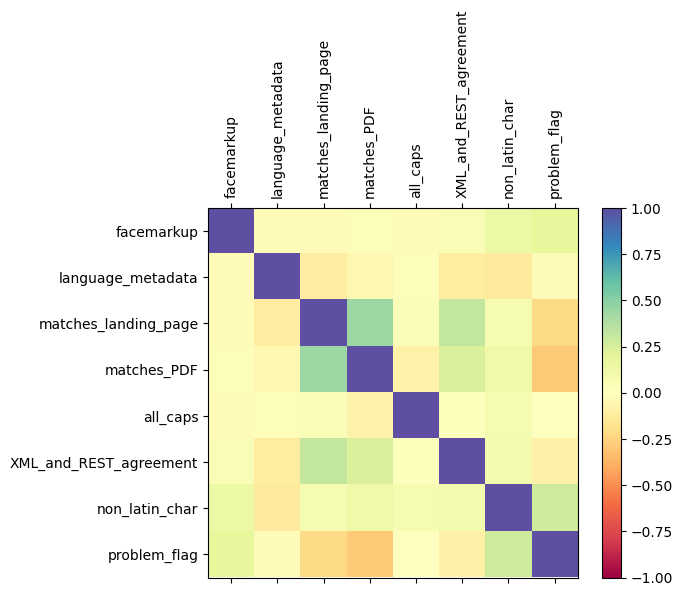

In [233]:
#correlation analysis among all variables except problem
#correlation
# ref:https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
# ref:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
import matplotlib.pyplot as plt
#need to convert any str to int, replace No:0, yes:1

data = abstract_subset_complete[['facemarkup','language_metadata','matches_landing_page', 'matches_PDF', 'all_caps', 'XML_and_REST_agreement','non_latin_char']]

data['problem_flag'] = abstract_subset_complete[abstract_subset_complete['problem']=='No problems']['problem']
data['problem_flag'] = data['problem_flag'].fillna(value='Problems found')


data['facemarkup'].replace({'MathML':1,'No':0,'HTML':2,'tex-math':3}, inplace=True)
data['language_metadata'] = data['language_metadata'].apply(lambda x: x.replace(x,'1') if x!='No' else x)
data['language_metadata'].replace({'No':0}, inplace=True)
data['language_metadata'] = data['language_metadata'].apply(lambda x: int(x))
data['matches_landing_page'].replace({'Yes':1,'No':0, 'Not available':np.nan}, inplace=True)
data['matches_PDF'].replace({'Yes':1,'No':0, 'Not available':np.nan}, inplace=True)
data['all_caps'].replace({'Yes':1,'No':0}, inplace=True)
data['XML_and_REST_agreement'].replace({'Yes':1,'No':0, 'Not available':np.nan}, inplace=True)
data['non_latin_char'].replace({'Yes':1,'No':0}, inplace=True)
data['problem_flag'].replace({'Problems found':1,'No problems':0}, inplace=True)
corr = data.corr(method='spearman')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='Spectral', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()


# Abstract subset analysis #2:
## expanding the middle token length to get more publishers
In the sample above, the proceedings-article was dominated by one publisher 
Optica, but this is the largest publisher in this area, plus there are others in the sample.
<br>>
I checked how many publishers are create proceedings-articles with this API call:<br>
https://api.crossref.org/works?mailto=pnriddle%40dal.ca&filter=from-pub-date:2020-01-01,has-abstract:1,type:proceedings-article&facet=publisher-name:*
<br>
### Here are the results of the top 10:<br>
Optica Publishing Group: 30728<br>
American Society of Mechanical Engineers: 25729<br>
SPE: 17758<br>
Crossref: 9104<br>
Sociedade Brasileira de Computação - SBC: 6925<br>
AHFE International: 6274<br>
SAE International: 5643<br>
Sociedade Brasileira de Computação: 5220<br>
International Joint Conferences on Artificial Intelligence Organization: 4656<br>
Zeppelini Editorial e Comunicação: 3484<br>
<br>
This seems a similar distribution
<br>No further action taken



## Patterns and applying to entire sample
purpose: identify patterns of problems and code these as string or regex. Apply to whole sample to get an idea of how many persist throughout sample. 


# Problems to pattern with string or regex:

includes multiple languages, hiragana, General Punc, Dingbats, etc.	28 --> check unicode block for character set
1. MathML	9 --> check for inclusion of MathML tags
2. includes hyperlinks	6 --> check for http:// or https:// with regex or string method
3. includes figure	6 --> check for string pattern "Figure" or "Fig"
4. includes HTML	4 --> check for string pattern with HTML tags
5. article title used as abstract	4 --> check if abstract = title string method
6. first element is empty, but others have abstract	3 --> XML API call - count elements, if over 1, check if any are empty
7. includes tex-math, not MathML	1 --> check for string pattern for tex-math tags
8. includes table	2 --> check for string pattern for table follwed by a number
9. includes copyright statement	1 --> check for string pattern copyright or c with the circle char
10. test doi	1 --> check DOI against list of known test DOIs

## purpose
The goal is to take problems identified in the subset and then look for those in a larger sample, developing code that can be used to check future samples. 

In [98]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# check for MathML Tags
# check for toplevel <math> first in known subset where DOI can be matched and manually checked
# import data
abstract_subset_complete = pd.read_excel("data/part_1_df_abstract_subset.xlsx")

In [104]:
def check_for_math_ml(abstract:str)->bool:
    math_pattern = r"(<mml:.*>)"
    if re.search(math_pattern, abstract):
        a=True
    else:
        a=False
    return a

def check_for_tex_math(abstract:str)->bool:
    pattern = r"(<jats:tex-math>)"
    if re.search(pattern, abstract):
        a=True
    else:
        a=False
    return a

# (http.*)|(?:!<mml:.*>)
def check_for_http(abstract:str)->bool:
    pattern = [r"(https://.*)", r"(http://.*)"]
    if re.search(pattern[0], abstract):
        a = True
    elif re.search(pattern[1], abstract):
        a = True
    else:
        a = False
    return a

def check_for_HTML(abstract:str)->bool:
    pattern = [r"(&lt)", r"(&gt)", r"(div class=.*)"] 
    if re.search(pattern[0], abstract):
        a = True
    elif re.search(pattern[1], abstract):
        a = True
    elif re.search(pattern[2], abstract):
        a = True
    else:
        a = False
    return a

def check_for_figure(abstract:str)->bool:
    pattern = [r"Figure \d*", r"Fig. \d*"]
    if re.search(pattern[0], abstract):
        a = True
    elif re.search(pattern[1], abstract):
        a = True
    else:
        a = False
    return a



abstract_check = abstract_subset_complete[['DOI', 'abstract']]
#apply function to new column
abstract_check['mathml_flag'] = abstract_check['abstract'].map(check_for_math_ml)
abstract_sum = abstract_subset_complete['DOI'].count()
print(f"\nCount of subset abstracts: {abstract_sum}")
#percentage of MathML counts of abstract_subset_complete
mml_counts = abstract_check.groupby(['mathml_flag']).count()/abstract_sum*100
mml_counts.to_excel("tables/mml_counts_subset.xlsx")

print(Fore.LIGHTBLUE_EX+ f"\nMathML Counts as percentage of abstract subset\n------\n{mml_counts}\n")

# of whole 10,000 sample from df_data
fullset_check = df_data[['DOI', 'abstract']]
#apply function to new column
fullset_check['mathml_flag'] = fullset_check['abstract'].map(check_for_math_ml)
abstract_sum = fullset_check['DOI'].count()
print(Fore.CYAN + f"\nCount of fullset: {abstract_sum}")
#percentage of MathML counts of abstract_subset_complete
mml_counts = fullset_check.groupby(['mathml_flag']).count()/abstract_sum*100
mml_counts.to_excel("tables/mml_counts_full_set.xlsx")

print(Fore.MAGENTA + f"\nMathML Counts as percentage of the full sample set\n------\n{mml_counts}\n")

# check for tex-math in subset
#apply function to new column
abstract_check['texmath_flag'] = abstract_check['abstract'].map(check_for_tex_math)
abstract_sum = abstract_subset_complete['DOI'].count()
print(f"\nCount of subset abstracts: {abstract_sum}")
#percentage of MathML counts of abstract_subset_complete
texmath_counts = abstract_check.groupby(['texmath_flag'])['DOI'].count()/abstract_sum*100
texmath_counts.to_excel("tables/texmath_counts_subset.xlsx")

print(Fore.LIGHTCYAN_EX + f"\n--------\nTex-math Counts as percentage of abstract subset\n------\n{mml_counts}\n")

# and check full set for tex-math
fullset_check['texmath_flag'] = fullset_check['abstract'].map(check_for_tex_math)
# percentage of those from full set with tex-math tags
abstract_sum = fullset_check['DOI'].count()
texmath_counts = fullset_check.groupby(['texmath_flag'])['DOI'].count()/abstract_sum*100
texmath_counts.to_excel("tables/texmath_counts_fullset.xlsx")
print(Fore.LIGHTGREEN_EX + f"\n-------\nPercentage of full set with tex-math tags: \n{texmath_counts}")


# check for https or https in abstract subset
#apply function to new column
abstract_check['https_flag'] = abstract_check['abstract'].map(check_for_http)
abstract_sum = abstract_subset_complete['DOI'].count()
#percentage of https or http counts of abstract_subset_complete
https_counts = abstract_check.groupby(['https_flag'])['DOI'].count()/abstract_sum*100
https_counts.to_excel("tables/https_counts_subset.xlsx")

print(Fore.LIGHTYELLOW_EX + f"\n------\nHttp counts as percentage of abstract subset, inclusive of MathML declarations: \n------\n{https_counts}\n")

# check for https or http on fullset
#apply function to new column
fullset_check['https_flag'] = fullset_check['abstract'].map(check_for_http)
abstract_sum = fullset_check['DOI'].count()
#percentage of https or http counts of fullset
https_counts = fullset_check.groupby(['https_flag'])['DOI'].count()/abstract_sum*100
https_counts.to_excel("tables/https_counts_fullset.xlsx")

print(Fore.LIGHTBLUE_EX + f"\n------\nHttp counts as percentage of fullset, inclusive of MathML declarations: \n------\n{https_counts}\n")

# check for HMTL tags in abstract subset using check_for_HTML()
#apply function to new column
abstract_check['HTML_flag'] = abstract_check['abstract'].map(check_for_HTML)
abstract_sum = abstract_subset_complete['DOI'].count()
#percentage of HTML tag counts of abstract_subset_complete
HTML_counts = abstract_check.groupby(['HTML_flag'])['DOI'].count()/abstract_sum*100
HTML_counts.to_excel("tables/HTML_counts_subset.xlsx")

print(Fore.LIGHTGREEN_EX + f"\n------\nHTML tag counts as percentage of abstract subset: \n------\n{HTML_counts}\n")

# check for HTML tags in fullset
fullset_check['HTML_flag'] = fullset_check['abstract'].map(check_for_HTML)
abstract_sum = fullset_check['DOI'].count()
#percentage of HTML tag counts of fullset
HTML_counts = fullset_check.groupby(['HTML_flag'])['DOI'].count()/abstract_sum*100
HTML_counts.to_excel("tables/HTML_counts_fullset.xlsx")

print(Fore.LIGHTMAGENTA_EX + f"\n------\nHTML tag counts as percentage of fullset: \n------\n{HTML_counts}\n")

# check for Figure or Fig followed by digit in subset using check_for_figure()
abstract_check['figure_flag'] = abstract_check['abstract'].map(check_for_figure)
abstract_sum = abstract_subset_complete['DOI'].count()
#percentage of Figure or Fig counts of abstract_subset_complete
figure_counts = abstract_check.groupby(['figure_flag'])['DOI'].count()/abstract_sum*100
figure_counts.to_excel("tables/figure_counts_subset.xlsx")

print(Fore.LIGHTYELLOW_EX + f"\n------\nFigure or Fig followed by digit counts as percentage of abstract subset: \n------\n{figure_counts}\n")

# check for Figure or Fig followed by digit in fullset using check_for_figure()
fullset_check['figure_flag'] = fullset_check['abstract'].map(check_for_figure)
abstract_sum = fullset_check['DOI'].count()
#percentage of HTML tag counts of fullset
figure_counts = fullset_check.groupby(['figure_flag'])['DOI'].count()/abstract_sum*100
figure_counts.to_excel("tables/figure_counts_fullset.xlsx")

print(Fore.LIGHTGREEN_EX + f"\n------\nFigure or Fig followed by digit counts as percentage of fullset: \n------\n{figure_counts}\n")



Count of subset abstracts: 300

MathML Counts as percentage of abstract subset
------
                   DOI   abstract
mathml_flag                      
False        97.666667  97.666667
True          2.333333   2.333333


Count of fullset: 10100

MathML Counts as percentage of the full sample set
------
                   DOI   abstract
mathml_flag                      
False        99.633663  99.633663
True          0.366337   0.366337


Count of subset abstracts: 300

--------
Tex-math Counts as percentage of abstract subset
------
                   DOI   abstract
mathml_flag                      
False        99.633663  99.633663
True          0.366337   0.366337


-------
Percentage of full set with tex-math tags: 
texmath_flag
False    99.643564
True      0.356436
Name: DOI, dtype: float64

------
Http counts as percentage of abstract subset, inclusive of MathML declarations: 
------
https_flag
False    93.0
True      7.0
Name: DOI, dtype: float64


------
Http counts as perce

In [ ]:
# create new df from abstract_subset and title_subset
abstract_subset_complete = pd.read_excel("data/part_1_df_abstract_subset.xlsx")
title_subset_complete = pd.read_excel("data/part_1_df_title_subset.xlsx")
# create new df from fullset df_data

# define function to check abstract to title
def check_abstract_is_title(abstract:str, title:str)->bool:
    if abstract = title:
        a = True
    else:
        a = False
    return a

# apply function to subset df

# apply function to fullset df
